In [1]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "mu3e_trigger_data"
SIGNAL_DATA_FILE = f"{DATA_DIR}/run42_sig_positions.npy"
BACKGROUND_DATA_FILE = f"{DATA_DIR}/run42_bg_positions.npy"

max_barrel_radius = 86.3
max_endcap_distance = 372.6

In [3]:
signal_data = np.load(SIGNAL_DATA_FILE)
background_data = np.load(BACKGROUND_DATA_FILE)

background_data[background_data[:, :, 0] != -1, 0] /= max_barrel_radius
background_data[background_data[:, :, 0] != -1, 1] /= max_barrel_radius
background_data[background_data[:, :, 0] != -1, 2] /= max_endcap_distance

signal_data[signal_data[:, :, 0] != -1, 0] /= max_barrel_radius
signal_data[signal_data[:, :, 0] != -1, 1] /= max_barrel_radius
signal_data[signal_data[:, :, 0] != -1, 2] /= max_endcap_distance

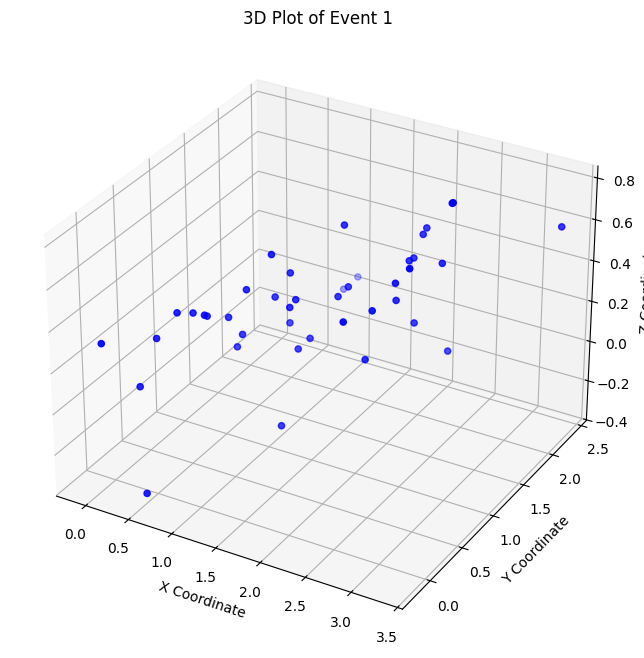

In [4]:
import matplotlib

# matplotlib.use('Qt5Agg')
hit_number = ((background_data != -1).all(axis=-1)).sum(axis=-1)

event_index = 1  # Index of the event to plot


event_location = background_data[event_index]

# Filter out padding values
valid_mask = ~(event_location == -1).any(axis=-1)
event_location = event_location[valid_mask]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    event_location[:, 0], event_location[:, 1], event_location[:, 2], c="b", marker="o"
)

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title(f"3D Plot of Event {event_index}")

plt.show()

In [5]:
from keras.losses import Loss
from keras.metrics import Metric


@keras.utils.register_keras_serializable(package="Custom", name="ChamferDistanceMasked")
class ChamferDistanceMasked(Loss):
    def __init__(self, padding_val=-1.0, name="chamfer_distance_masked"):
        super().__init__(name=name)
        self.padding_val = padding_val

    def call(self, y_true, y_pred):
        """
        y_true: (B, N, D)
        y_pred: (B, M, D)
        """
        padding_val = self.padding_val

        # Masks: (B, N) and (B, M)
        mask_true = tf.reduce_any(
            tf.not_equal(y_true, padding_val), axis=-1
        )  # valid = True
        mask_pred = tf.reduce_any(tf.not_equal(y_pred, padding_val), axis=-1)

        # Expand dims for broadcasting
        y_true_exp = tf.expand_dims(y_true, axis=2)  # (B, N, 1, D)
        y_pred_exp = tf.expand_dims(y_pred, axis=1)  # (B, 1, M, D)

        # Compute squared distances
        diff = y_true_exp - y_pred_exp
        dist = tf.reduce_sum(tf.square(diff), axis=-1)  # (B, N, M)

        # Min distances
        min_true_to_pred = tf.reduce_min(dist, axis=2)  # (B, N)
        min_pred_to_true = tf.reduce_min(dist, axis=1)  # (B, M)

        # Zero-out invalid entries (inf) and compute mean over valid
        valid_min_true_to_pred = tf.where(
            mask_true, min_true_to_pred, tf.zeros_like(min_true_to_pred)
        )
        valid_min_pred_to_true = tf.where(
            mask_pred, min_pred_to_true, tf.zeros_like(min_pred_to_true)
        )

        sum_true = tf.reduce_sum(valid_min_true_to_pred)
        sum_pred = tf.reduce_sum(valid_min_pred_to_true)

        count_true = tf.reduce_sum(tf.cast(mask_true, tf.float32))
        count_pred = tf.reduce_sum(tf.cast(mask_pred, tf.float32))

        # Avoid division by zero
        mean_true_to_pred = sum_true / (count_true + 1e-8)
        mean_pred_to_true = sum_pred / (count_pred + 1e-8)

        return mean_true_to_pred + mean_pred_to_true


class MaskedMSE(Loss):
    def __init__(self, padding_value=-1.0, name="masked_mse"):
        super(MaskedMSE, self).__init__(name=name)
        self.padding_value = padding_value

    def call(self, y_true, y_pred):
        mask = tf.not_equal(y_true, self.padding_value)
        squared_diff = tf.square(y_true - y_pred)
        masked_squared_diff = tf.where(mask, squared_diff, tf.zeros_like(squared_diff))
        return tf.reduce_sum(masked_squared_diff) / tf.reduce_sum(
            tf.cast(mask, tf.float32) + 1e-8
        )


class MaskConcatMSE(Loss):
    def __init__(self, padding_value=-1.0, name="masked_concat_mse"):
        super(MaskConcatMSE, self).__init__(name=name)
        self.padding_value = padding_value

    def call(self, y_true, y_pred):
        y_pred, y_true = tf.split(
            y_pred, 2, axis=-1
        )  # Assuming y_true and y_pred are concatenated
        mask = tf.not_equal(y_true, self.padding_value)

        squared_diff = tf.square(y_true - y_pred)
        masked_squared_diff = tf.where(mask, squared_diff, tf.zeros_like(squared_diff))
        return tf.reduce_sum(masked_squared_diff) / tf.reduce_sum(
            tf.cast(mask, tf.float32) + 1e-8
        )

In [11]:
from keras.layers import Layer, Dense


class MaskedSetSorter(keras.layers.Layer):
    def __init__(self, **kwargs):
        """
        Sorts each set along a precomputed ranking magnitude, ignoring masked entries.
        """
        super().__init__(**kwargs)

    def call(self, inputs, mask=None):
        """
        Args:
            inputs: Tuple (set_inputs, mag)
                - set_inputs: Tensor [B, N, d]
                - mag: Tensor [B, N, 1]
            mask: Tensor [B, N], True for valid entries
        Returns:
            sorted_x: Tensor [B, N, d]
        """
        set_inputs, mag = inputs
        mag = tf.abs(mag)

        if mask is not None:
            mask = tf.cast(mask, dtype=tf.bool)
            # Compute per-sample max mag: [B, 1, 1]
            max_per_sample = tf.reduce_max(mag, axis=1, keepdims=True)
            large_val = max_per_sample + 1.0
            mag = tf.where(mask, mag, tf.broadcast_to(large_val, tf.shape(mag)))

        # Sort by mag[..., 0]
        sort_indices = tf.argsort(mag[:, :, 0], axis=1, direction='ASCENDING')  # [B, N]
        sorted_x = tf.gather(set_inputs, sort_indices, batch_dims=1)

        return sorted_x

    def compute_output_shape(self, input_shape):
        return input_shape[0]

class GenerateMask(keras.Model):
    def __init__(self, padding_value=-1, **kwargs):
        super(GenerateMask, self).__init__(**kwargs)
        self.padding_value = padding_value

    def call(self, inputs):
        mask = tf.not_equal(inputs, self.padding_value)
        return tf.cast(tf.reduce_any(mask, axis=-1, keepdims=True), dtype=tf.bool)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (input_shape[-1],)


class MaskOutput(keras.layers.Layer):
    def __init__(self, padding_value=-1, **kwargs):
        super(MaskOutput, self).__init__(**kwargs)
        self.padding_value = padding_value

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = tf.broadcast_to(mask, tf.shape(inputs))
            inputs = tf.where(
                mask,
                inputs,
                self.padding_value * tf.ones_like(inputs, dtype=inputs.dtype),
            )
        return inputs

    def compute_output_shape(self, input_shape):
        return input_shape


class GetSequenceLength(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GetSequenceLength, self).__init__(**kwargs)

    def call(self, inputs):
        mask = tf.cast(inputs, tf.int32)
        return tf.reduce_sum(mask, axis=-2, keepdims=False)

    def compute_output_shape(self, input_shape):
        return (
            input_shape[0],
            1,
        )  # Output shape is the same as input shape except the last dimension is replaced with 1


class SumOverSequenceLength(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SumOverSequenceLength, self).__init__(**kwargs)

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = tf.broadcast_to(mask, tf.shape(inputs))
            inputs = tf.where(mask, inputs, tf.zeros_like(inputs, dtype=inputs.dtype))
        return tf.reduce_sum(inputs, axis=1, keepdims=True)

    def compute_output_shape(self, input_shape):
        return (
            input_shape[0],
            1,
            input_shape[-1],
        )  # Keep the feature dimension unchanged


class GenerateDecoderMask(keras.layers.Layer):
    def __init__(self, max_length=256, **kwargs):
        super().__init__(**kwargs)
        self.max_length = max_length

    def call(self, inputs):
        # inputs: shape (batch_size, 1) or (batch_size,)
        predicted_seq_length = tf.cast(tf.round(tf.squeeze(inputs)), tf.int32)
        # clip to max_length
        predicted_seq_length = tf.clip_by_value(
            predicted_seq_length, 0, self.max_length
        )
        # create sequence mask
        mask = tf.sequence_mask(
            predicted_seq_length, maxlen=self.max_length, dtype=tf.bool
        )
        # expand dims to (batch_size, max_length, 1)
        return tf.expand_dims(mask, axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.max_length, 1)


class PositionalEncoding(Layer):
    def __init__(self, dim, mode="onehot", padding_value=-1, **kwargs):
        """
        Args:
            dim (int): Encoding dimension.
            mode (str): One of ['onehot', 'binary', 'sinusoid'].
            padding_value (int/float): Value to use for masked positions.
        """
        super().__init__(**kwargs)
        self.dim = dim
        self.mode = mode
        self.padding_value = padding_value
        self.supports_masking = True  # Ensure compatibility with Keras masking

    def call(self, inputs, mask=None):
        """
        Args:
            x: Tensor of indices [B, N]
            mask: Boolean mask of shape [B, N, 1] (True = valid)

        Returns:
            Tensor of shape [B, N, dim]
        """

        x = tf.range(tf.shape(inputs)[-2], dtype=tf.int32)

        if self.mode == "onehot":
            enc = tf.one_hot(x, depth=self.dim, dtype=tf.float32)

        elif self.mode == "sinusoid":
            enc = self.sinusoidal(x)

        else:
            raise ValueError(f"Unsupported mode: {self.mode}")
        # Reshape to [B, N, dim]
        enc = tf.expand_dims(enc, axis=0)
        enc = tf.tile(enc, [tf.shape(inputs)[0], 1, 1])  # [B, N, dim]

        # Apply mask if present
        if mask is not None:
            # Ensure mask has shape [..., 1] to match encodings
            mask = tf.cast(mask, tf.bool)
            mask = tf.broadcast_to(mask, tf.shape(enc))  # [B, N, dim]
            enc = tf.where(mask, enc, tf.ones_like(enc) * self.padding_value)
        return enc

    def sinusoidal(self, x):
        x = tf.cast(x, tf.float32)
        x_shape = tf.shape(x)
        pos = tf.reshape(x, [-1])  # [B*N]

        i = tf.range(self.dim, dtype=tf.float32)
        angle_rates = 1 / tf.pow(
            10000.0, (2 * (i // 2)) / tf.cast(self.dim, tf.float32)
        )
        angles = tf.expand_dims(pos, -1) * angle_rates  # [B*N, dim]

        enc = tf.where(
            tf.cast(tf.expand_dims(i % 2 == 0, 0), tf.bool),
            tf.sin(angles),
            tf.cos(angles),
        )

        return tf.reshape(enc, tf.concat([x_shape, [self.dim]], axis=0))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.dim,)


class SelfAttentionBlock(keras.layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attention = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=key_dim, name="self_attention_layer"
        )
        self.ff_layer = keras.layers.Dense(
            key_dim, activation="relu", name="self_attention_ffn_layer"
        )
        self.layer_norm_1 = keras.layers.LayerNormalization(
            name="self_attention_layer_norm_1"
        )
        self.layer_norm_2 = keras.layers.LayerNormalization(
            name="self_attention_layer_norm_2"
        )

    def call(self, inputs, mask=None):
        # inputs: shape (batch_size, sequence_length, feature_dim)
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        # Add residual connection
        attention_output = keras.layers.Add()([inputs, attention_output])
        # Apply first layer normalization
        attention_output = self.layer_norm_1(attention_output)

        # Apply feedforward network
        ff_output = self.ff_layer(attention_output)
        # Add residual connection
        ff_output = keras.layers.Add()([attention_output, ff_output])
        # Apply second layer normalization
        ff_output = self.layer_norm_2(ff_output)

        return ff_output

    def compute_output_shape(self, input_shape):
        return input_shape  # Output shape is the same as input shape


class MLP(keras.layers.Layer):
    def __init__(
        self,
        input_dim,
        output_dim,
        num_layers=3,
        layer_norm=False,
        activation="swish",
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layer_norm = layer_norm

        # Interpolate hidden dimensions between input_dim and output_dim
        node_list = [
            int(input_dim + (output_dim - input_dim) * (i / (num_layers)))
            for i in range(1, num_layers)
        ]

        self.layers_list = []
        for i, width in enumerate(node_list):
            self.layers_list.append(
                keras.layers.Dense(width, activation="relu", name=f"mlp_dense_{i}")
            )
            if layer_norm:
                self.layers_list.append(
                    keras.layers.LayerNormalization(name=f"mlp_layer_norm_{i}")
                )

        self.layers_list.append(
            keras.layers.Dense(
                output_dim, activation=activation, name="mlp_dense_output"
            )
        )
        if layer_norm:
            self.layers_list.append(
                keras.layers.LayerNormalization(name="mlp_layer_norm_output")
            )

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)
        return x

    def compute_output_shape(self, input_shape):
        return (*input_shape[:-1], self.output_dim)


In [12]:
latent_dim = 200
sequence_length = 128
n_head = 8
input = keras.Input(shape=(sequence_length, 3), name="input_layer")


# Build encoder
mask = GenerateMask(padding_value=-1, name="mask_layer")(input)
sequence_length_input = GetSequenceLength(name="sequence_length_layer")(mask)
flatted_mask = keras.layers.Flatten(name="flatten_mask_layer")(mask)
sorting_magnitude = keras.layers.Dense(1, name="sorting_magnitude_layer")(input)
ordered_input = MaskedSetSorter(name="set_sorter_layer")(
    [input, sorting_magnitude], mask=mask
)


# Encode the input
input_embedding = MLP(
    input_dim=3,
    output_dim=latent_dim,
    num_layers=3,
    activation="swish",
    name="input_embedding_mlp_layer",
    layer_norm=True
)(ordered_input)


# Encode the position
position_encoding = PositionalEncoding(
    padding_value=-1, dim=latent_dim, name="positional_encoding_layer"
)(input_embedding, mask=mask)


# Multiply input and position encodings
input_position_product = keras.layers.Multiply(name="input_position_product_layer")(
    [input_embedding, position_encoding]
)

# Encode sequence length
sequence_length_embedding = MLP(
    input_dim= latent_dim,
    output_dim=latent_dim,
    num_layers=2,
    activation="relu",
    name="sequence_length_embedding_mlp_layer",
    layer_norm=True
)(keras.layers.Reshape(target_shape=(latent_dim,))(keras.layers.RepeatVector(latent_dim, name="repeat_sequence_length_layer")(
    sequence_length_input
)))

# Sum over the sequence length dimension
input_position_sum = SumOverSequenceLength(name="input_position_sum_layer")(
    input_position_product, mask=mask
)
latent_output = keras.layers.Add(name="latent_output_layer")(
    [input_position_sum, sequence_length_embedding]
)


# Build decoder
decoded_sequence_length = MLP(
    input_dim=latent_dim,
    output_dim=1,
    num_layers=2,
    activation="swish",
    layer_norm=True,
    name="decoded_sequence_length_mlp_layer",
)(latent_output)
decoded_sequence_mask = GenerateDecoderMask(
    max_length=sequence_length, name="decoder_mask_layer"
)(decoded_sequence_length)



# Build key-value latent embedding
tiled_latent_output = keras.layers.RepeatVector(
    sequence_length, name="tile_latent_output_layer"
)(keras.layers.Flatten(name="flatten_latent_output_layer")(latent_output))

# Build decoder queries
decoder_queries = PositionalEncoding(
    padding_value=-1, dim=latent_dim, name="decoder_keys_positional_encoding_layer"
)(tiled_latent_output, mask=decoded_sequence_mask)

# Build decoder keys
decoder_values = keras.layers.Dense(
    latent_dim, activation="relu", name="decoder_values_dense_layer_1"
)(tiled_latent_output)
decoder_values = keras.layers.Dense(
    latent_dim, activation="relu", name="decoder_values_dense_layer_2"
)(decoder_values)

# Multiply decoder queries and keys
decoder_multiply = keras.layers.Multiply(name="decoder_queries_multiply_layer")(
    [decoder_queries, decoder_values]
)


# Build decoder values
decoded_values = MLP(
    input_dim=latent_dim,
    output_dim=3,
    num_layers=3,
    activation="linear",
    name="decoder_values_mlp_layer",
)(decoder_multiply)

# Mask decoder output
decoder_values = MaskOutput(padding_value=-1, name="decoder_values_mask_layer")(
    decoded_values, mask=decoded_sequence_mask
)
masked_output = decoder_values
concat_output = keras.layers.Concatenate(axis=-1, name="concat_output_layer")(
    [masked_output, ordered_input]
)
length_output = decoded_sequence_length

In [13]:
autoencoder = keras.Model(
    inputs=[input],
    outputs=[concat_output, length_output],
    name="mu3e_trigger_autoencoder",
)
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=[MaskConcatMSE, "mse"],
    loss_weights=[100, 1],
)
autoencoder.summary()

Model: "mu3e_trigger_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sorting_magnitude_… │ (None, 128, 1)    │          4 │ input_layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_layer          │ (None, 128, 3)    │          0 │ input_layer[0][0] │
│ (GenerateMask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ set_sorter_layer    │ (None, 128, 3)    │          0 │ input_layer[0][0… │
│ (MaskedSetSorter)   │                   │            │ sorting_magnitud… │
│                     │                   │            │ mask_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_embedding_ml… │ (None, 128, 200)  │     37,322 │ set_sorter_layer… │
│ (MLP)               │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_length_la… │ (None, 1)         │          0 │ mask_layer[0][0]  │
│ (GetSequenceLength) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 128, 200)  │          0 │ input_embedding_… │
│ (PositionalEncodin… │                   │            │ mask_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_sequence_le… │ (None, 200, 1)    │          0 │ sequence_length_… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_position_pro… │ (None, 128, 200)  │          0 │ input_embedding_… │
│ (Multiply)          │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 200)       │          0 │ repeat_sequence_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_position_sum… │ (None, 1, 200)    │          0 │ input_position_p… │
│ (SumOverSequenceLe… │                   │            │ mask_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequence_length_em… │ (None, 200)       │     81,200 │ reshape_1[0][0]   │
│ (MLP)               │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_output_layer │ (None, 1, 200)    │          0 │ input_position_s… │
│ (Add)               │                   │            │ sequence_length_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_latent_out… │ (None, 200)       │          0 │ latent_output_la… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tile_latent_output… │ (None, 128, 200)  │          0 │ flatten_latent_o… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoded_sequence_l… │ (None, 1, 1)      │     20,403 │ latent_output_la… │
│ (MLP)               │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_mask_layer  │ (None, 128, 1)    │          0 │ decoded_sequence

 Total params: 255,650 (998.63 KB)

 Trainable params: 255,650 (998.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
training_data = background_data[
    :40000, :sequence_length, :
]  # Use a subset for training
tranining_data_sequence_length = np.sum(
    (training_data != -1).any(axis=-1), axis=-1
)  # Calculate sequence lengths for the training data

In [15]:
history = autoencoder.fit(
    training_data,
    [training_data, tranining_data_sequence_length],
    epochs=20,
    batch_size=512,
    validation_split=0.2,
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 785ms/step - concat_output_layer_loss: 5.0752 - decoded_sequence_length_mlp_layer_loss: 2701.0208 - loss: 3208.5632 - val_concat_output_layer_loss: 4.9624 - val_decoded_sequence_length_mlp_layer_loss: 2619.7019 - val_loss: 3120.0105
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 874ms/step - concat_output_layer_loss: 4.9699 - decoded_sequence_length_mlp_layer_loss: 2678.4082 - loss: 3175.4087 - val_concat_output_layer_loss: 4.9568 - val_decoded_sequence_length_mlp_layer_loss: 2568.1458 - val_loss: 3067.8398
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 958ms/step - concat_output_layer_loss: 4.9423 - decoded_sequence_length_mlp_layer_loss: 2624.7771 - loss: 3118.9424 - val_concat_output_layer_loss: 4.8461 - val_decoded_sequence_length_mlp_layer_loss: 2517.8545 - val_loss: 3006.4465
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - concat_output_layer_loss: 4.8535 - decoded_sequence_length_mlp_layer_loss: 2547.8945 - loss: 3033.1528 - val_concat_output_

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


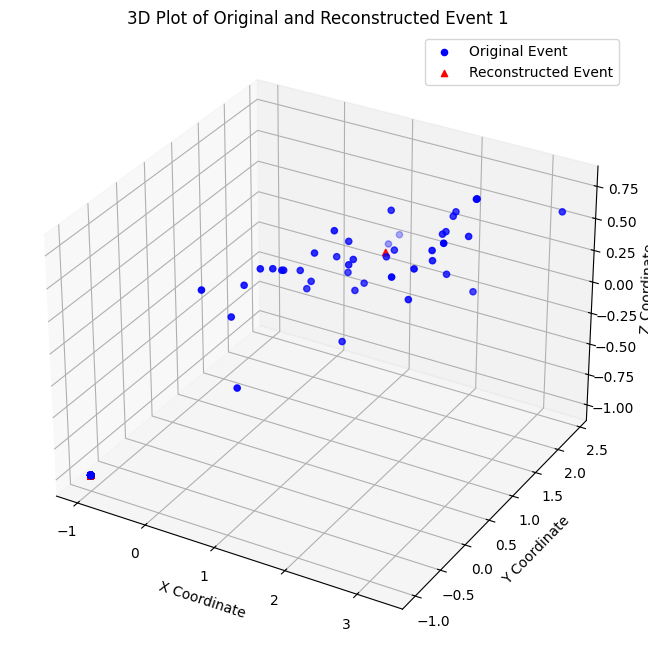

In [16]:
# Select an event to visualize
event_index = 1  # Change this index to visualize a different event
original_event = training_data[event_index, :, :].reshape(
    1, sequence_length, 3
)  # Reshape to match input shape


reconstructed_event, length = autoencoder.predict(original_event)

# Filter out padding values
# valid_mask = ~(original_event == -1).any(axis=-1)
# original_event = original_event[valid_mask]

# Get the reconstructed event from the autoencoder
# reconstructed_event = autoencoder.predict([original_event,sequence_length])
reconstructed_event = reconstructed_event
# reconstructed_event = reconstructed_event[~np.all(reconstructed_event == -1, axis=1)]  # Filter out rows with all -1

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter3D(
    original_event[0, :, 0],
    original_event[0, :, 1],
    original_event[0, :, 2],
    c="b",
    marker="o",
    label="Original Event",
)
ax.scatter3D(
    reconstructed_event[0, :, 0],
    reconstructed_event[0, :, 1],
    reconstructed_event[0, :, 2],
    c="r",
    marker="^",
    label="Reconstructed Event",
)
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title(f"3D Plot of Original and Reconstructed Event {event_index}")
ax.legend()
plt.show()

In [17]:
reconstructed_event

array([[[ 1.454661  ,  1.4618727 ,  0.29965824,  0.8251019 ,
          0.84978545,  0.18174987],
        [ 1.454661  ,  1.4618727 ,  0.29965824,  1.2813697 ,
          1.0877829 ,  0.10018787],
        [ 1.454661  ,  1.4618727 ,  0.29965824,  0.6955352 ,
          0.8131963 ,  0.25966182],
        [ 1.454661  ,  1.4618727 ,  0.29965824,  1.3333403 ,
          1.1991197 ,  0.12799248],
        [ 1.454661  ,  1.4618727 ,  0.29965824,  1.0063866 ,
          1.1042719 ,  0.3175255 ],
        [ 1.454661  ,  1.4618727 ,  0.29965824,  0.20487265,
          0.13993026,  0.04779925],
        [-1.        , -1.        , -1.        ,  0.23031698,
          0.35498667,  0.2263285 ],
        [-1.        , -1.        , -1.        ,  0.56357896,
          0.6699425 ,  0.28891572],
        [-1.        , -1.        , -1.        ,  1.3548279 ,
          0.7346402 , -0.17015566],
        [-1.        , -1.        , -1.        ,  1.1120052 ,
          1.1964777 ,  0.42259797],
        [-1.        , -1.     